In [4]:
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import resnet50
from data_preparation import get_dataloaders
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data
batch_size = 64
trainloader, testloader = get_dataloaders(batch_size)

# Model
class ResNet50Fingerprint(nn.Module):
    def __init__(self):
        super(ResNet50Fingerprint, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final classification layer
        self.fc = nn.Linear(2048, 1)  # Add a new classification layer for binary output

    def forward(self, x1, x2):
        f1 = self.resnet(x1)
        f2 = self.resnet(x2)
        # Compute absolute difference between features
        diff = torch.abs(f1 - f2)
        out = self.fc(diff)
        return out

model = ResNet50Fingerprint().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
torch.cuda.empty_cache()

Number of same pairs: 27000
Number of different pairs: 300000
Number of balanced different pairs: 27000


C:\tools\Anaconda3\envs\LoRA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\tools\Anaconda3\envs\LoRA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Accuracy : 78.02 %, Loss: 0.588, F1 Score: 0.780
TP: 4198, FP: 1079, TN: 4228, FN: 1295
Epoch 2/10, Accuracy : 84.18 %, Loss: 0.412, F1 Score: 0.855
TP: 5031, FP: 1247, TN: 4060, FN: 462
Epoch 3/10, Accuracy : 88.45 %, Loss: 0.275, F1 Score: 0.893
TP: 5190, FP: 944, TN: 4363, FN: 303
Epoch 4/10, Accuracy : 91.81 %, Loss: 0.173, F1 Score: 0.922
TP: 5203, FP: 594, TN: 4713, FN: 290
Epoch 5/10, Accuracy : 94.00 %, Loss: 0.103, F1 Score: 0.943
TP: 5350, FP: 505, TN: 4802, FN: 143
Epoch 6/10, Accuracy : 95.33 %, Loss: 0.064, F1 Score: 0.955
TP: 5360, FP: 371, TN: 4936, FN: 133
Epoch 7/10, Accuracy : 96.06 %, Loss: 0.038, F1 Score: 0.962
TP: 5399, FP: 331, TN: 4976, FN: 94
Epoch 8/10, Accuracy : 96.59 %, Loss: 0.025, F1 Score: 0.967
TP: 5443, FP: 318, TN: 4989, FN: 50
Epoch 9/10, Accuracy : 96.84 %, Loss: 0.015, F1 Score: 0.970
TP: 5461, FP: 309, TN: 4998, FN: 32
Epoch 10/10, Accuracy : 97.15 %, Loss: 0.010, F1 Score: 0.973
TP: 5470, FP: 285, TN: 5022, FN: 23


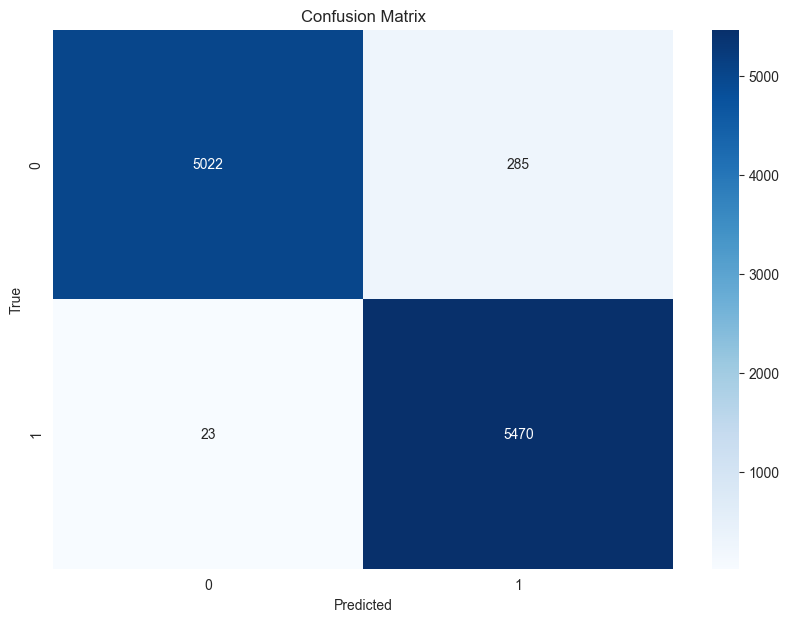

Finished Training


In [6]:
# Initialize TensorBoard
writer = SummaryWriter('runs/Fine-Tuning')

# Training The Model
epochs = 10
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        (inputs1, inputs2), labels = data
        inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs1, inputs2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader)
    
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data in testloader:
            (images1, images2), labels = data
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images1, images2)
            predictions = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    epoch_accuracy = 100 * correct / total
    epoch_f1 = f1_score(all_labels, all_predictions)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()

    # Log loss, accuracy, and F1 score for the epoch to TensorBoard
    writer.add_scalar('Accuracy/test', epoch_accuracy, epoch)
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('F1_Score/test', epoch_f1, epoch)
    
    print(f'Epoch {epoch+1}/{epochs}, Accuracy : {epoch_accuracy:.2f} %, Loss: {epoch_loss:.3f}, F1 Score: {epoch_f1:.3f}')
    print(f'TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')

# Visualize confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Finished Training')
writer.close()